# Random maps with `random_grid`

In [2]:
from qreative import random_grid
import numpy as np
import matplotlib.pyplot as plt
import random

The `random_grid` tool creates random grids using quantum computing. However, you may find yourself limited to fairly small grids. This is true both for when you simulate the jobs with normal computers (because large grids take ages to simulate) and when you use a real device (because of the limited size of current prototypes. For this reason, here we are going to generate large grids by sticking many small grids together.

Our first job is to deal with the output of `random_grid`. Each grid is represented as a string, with `'\n'` used for linebreaks.

In [29]:
grid = random_grid(4,4)
grid_stats,grid_data = grid.get_samples(shots=1,noisy=0.2)
print(grid_data)

['1000\n0010\n0000\n0000']


First we'll define a function to convert this to an array. We'll use use the integers 0 and 1 in this array, instead of their corresoonding strings.

In [30]:
def string2array (string):
    grid_list = []
    for line in string.split('\n'):
        grid_list.append( [int(char) for char in line] )
    return np.array(grid_list)

In [31]:
print( string2array( '1000\n0010\n0000\n0000' ) )

[[1 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 0 0 0]]


The function below creates a large map by breaking it down into a number of cells. Each cell is a grid generated quantumly using `random_grid`, so we shouldn't make them too big. The size of the cell is set by the `cell=(a,b)` kwarg, which specifies an `a`$\times$`b` grid. These cells are then tiled in an `A`$\times$`B` grid, as specified by the `size=(A,B)` kwarg.

This function is set up to generate a map with land and sea corresponding to 0 and 1 respectively. Each island is grown from a seed 1 that is randomly placed within its cell. The number of seeds in each cell is specified by the `seeds` kwarg. If this is less than 1, it is treated as a probability to put a seed in each cell.

Once the seeds are placed, sweeps of `CNOT` gates are used to grow the islands. The number of sweeps is given by the `sweeps` kwarg, and there is also a `frac` kwarg to set the fraction of a `NOT` that each applied. The axis of the `CNOT`s are randomly chosen by those provided in the `basis` kwarg. This randomly chooses from `'x'` and `'y'` by default, but you can use `axes=['x']` to make it certain to choose `'x'`, etc.

Noise makes things a bit more random.

In [58]:
def random_map (size=(4,4),cell=(4,4),seeds=1,sweeps=1,axes=['x','y'],frac=1,shots=1,noisy=False):
    cell_maps = [ [] for _ in range(shots) ]
    
    # loop over all cells, and 
    for Y in range(size[1]):
        cell_lines = [ [] for _ in range(shots) ]
        for X in range(size[0]):
            grid = random_grid(cell[0],cell[1])
            
            # place the seeds
            if seeds>=1:
                for seed in range(int(seeds)):
                    coords = (random.randrange(cell[0]),random.randrange(cell[1]))
                    grid.NOT( coords )
            elif random.random()<seeds:
                coords = (random.randrange(cell[0]),random.randrange(cell[1]))
                grid.NOT( coords )
            
            # sweep over qubits in cell and apply cnots to neighbours
            for sweep in range(sweeps):
                for y in range(cell[1]):
                    # in each sweep, half the qubits act as controls to the cnots, and half as targets
                    # they then alternate roles from one sweep to the next
                    # the dividing of qubits into two groups is on in 'checkerboard pattern
                    for x in range((y+sweep)%2,cell[0],2): # sweeps
                        for (xx,yy) in [(x+1,y),(x-1,y),(x,y+1),(x,y-1)]:
                            if (xx in range(cell[0])  and (yy in range(cell[1]))):
                                axis = random.choice(axes)
                                grid.CNOT((x,y),(xx,yy),frac=frac,axis=axis)
            
            # collect the results
            _,grid_data = grid.get_samples(shots=shots,noisy=noisy)
            for sample in range(shots):
                cell_lines[sample].append( string2array(grid_data[sample]) )
        for sample in range(shots):
            cell_maps[sample].append( cell_lines[sample] )
    
    # create the final grid
    maps = []
    for cell_map in cell_maps:
        maps.append( np.block(cell_map) )
    return maps

In this function, each cell is entirely independent. There is no way for an island to grow beyond the borders of its home cell (though it might end up touching one from a neighbouring cell). There are many ways that this could be fixed, and you could probably think of a better one than me!

Until then, here are some quantum islands.

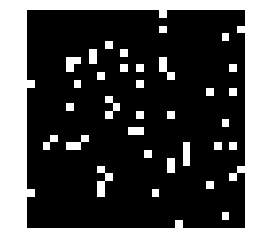

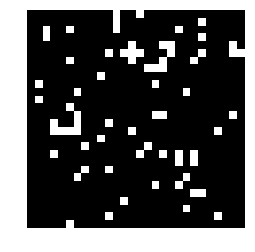

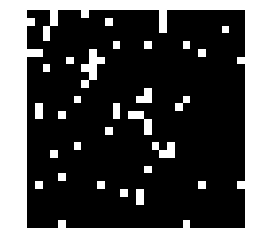

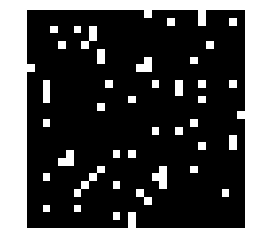

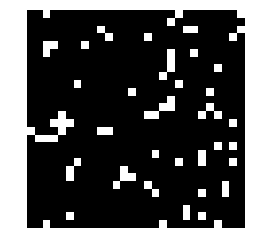

In [66]:
maps = random_map(size=(7,7),cell=(4,4),seeds=0,sweeps=1,frac=0.5,shots=5,noisy=0.015)

for map_sample in maps:
    plt.imshow(map_sample,cmap='gray')
    plt.axis('off')
    plt.show()